**Looking at Nashville Airbnb Data**

In order to plan a holiday you want to book the best accomodation possible. This notebook will look at airbnb data from Nashville to see
* What time of year is the cheapest to visit
* How big Nashville airbnbs are
* What features to look out for in an airbnb listing

First lets get the airbnb calendar data

In [85]:
# Import necessary libraries and read the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

calendar_df = pd.read_csv('./calendar.csv')
calendar_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,6422,2020-05-18,f,$40.00,$40.00,1.0,730.0
1,1844680,2020-05-19,f,$50.00,$50.00,1.0,1125.0
2,1844680,2020-05-20,f,$50.00,$50.00,1.0,1125.0
3,1844680,2020-05-21,f,$50.00,$50.00,1.0,1125.0
4,1844680,2020-05-22,f,$51.00,$51.00,1.0,1125.0


In [2]:
calendar_df.dtypes

listing_id          int64
date               object
available          object
price              object
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object

First to explore the data properly we will need to change the formats of the object columns

In [3]:
#Changing date column to a datetime format
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

#Changing available to a bool rather than string
calendar_df.replace({'available': {'t': True, 'f': False}}, inplace=True)

#Removing the $ sign from the two price columns
calendar_df['price'] = calendar_df['price'].str.replace(',', '').str.replace('$', '').astype(float)
calendar_df['adjusted_price'] = calendar_df['adjusted_price'].str.replace(',', '').str.replace('$', '').astype(float)

In [4]:
calendar_df.dtypes

listing_id                 int64
date              datetime64[ns]
available                   bool
price                    float64
adjusted_price           float64
minimum_nights           float64
maximum_nights           float64
dtype: object

In [5]:
calendar_df.describe()

,listing_id,price,adjusted_price,minimum_nights,maximum_nights
count,2.602203e+06,2.602203e+06,2.602203e+06,2.602100e+06,2.602100e+06
mean,2.743255e+07,4.163606e+02,4.154632e+02,5.391854e+00,1.084431e+06
std,1.153207e+07,2.172259e+05,2.172259e+05,1.502799e+01,4.822703e+07
min,6.422000e+03,1.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.905304e+07,1.020000e+02,1.010000e+02,1.000000e+00,3.650000e+02
50%,2.934593e+07,1.760000e+02,1.750000e+02,2.000000e+00,1.125000e+03
75%,3.780863e+07,3.050000e+02,3.020000e+02,3.000000e+00,1.125000e+03
max,4.346961e+07,3.504143e+08,3.504143e+08,5.500000e+02,2.147484e+09


Start investigating the data - there are two different prices given so we want to see how often the price is adjusted before dropping one of the columns

In [6]:
calendar_df['price_difference'] = calendar_df['price'] - calendar_df['adjusted_price']
calendar_df['price_difference'].value_counts()

 0.0      2510521
 17.0        4241
 20.0        3534
 4.0         3322
 15.0        3282
           ...   
 506.0          1
-128.0          1
 221.0          1
-31.0           1
-37.0           1
Name: price_difference, Length: 413, dtype: int64

As 98% of the adjusted prices are the same as the price we can drop the price column and take the adjusted price as the final price

In [7]:
calendar_df.drop(columns=['price','price_difference'], inplace=True)

Next we want to remove any rows that aren't suitable for our trip. This includes properties that require a stay of more than 7 nights as we're only looking at a vacation. We can also assume that the trip will be at least three nights for the majority of people

In [8]:
calendar_df = calendar_df[calendar_df['minimum_nights'] < 7.0]
calendar_df = calendar_df[calendar_df['maximum_nights'] > 3.0]

# Also remove any cases where the host has set a ridiculously high price
calendar_df = calendar_df[calendar_df['adjusted_price'] < 10000.0]

Now we want to see how price varies across the year

In [9]:
# Remove columns that are no longer needed
calendar_df.drop(columns=['listing_id','minimum_nights', 'maximum_nights'], inplace=True)

In [10]:
weekly_pricing = calendar_df.groupby(pd.Grouper(key='date', freq='W')).mean()

In [11]:
weekly_pricing.head()

,available,adjusted_price
date,,
2020-05-24,0.479436,223.771632
2020-05-31,0.589157,221.821028
2020-06-07,0.626810,267.127291
2020-06-14,0.629082,247.501960
2020-06-21,0.635228,247.750346


/Users/Neel/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


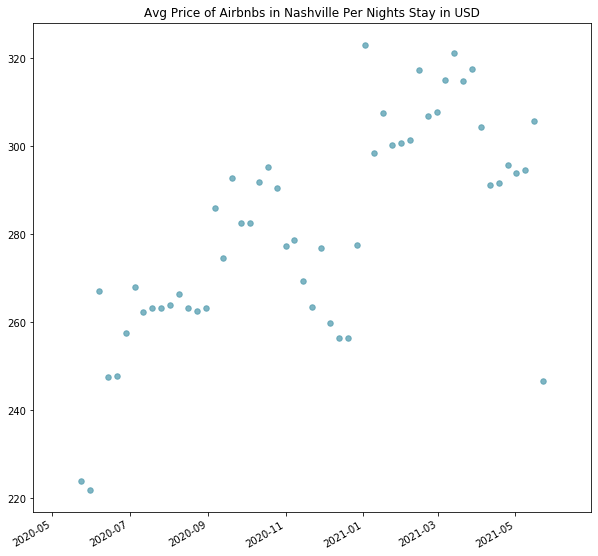

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(weekly_pricing.index, weekly_pricing.adjusted_price, s = 30, color = '#539caf', alpha = 0.75)

ax.set_title('Avg Price of Airbnbs in Nashville Per Nights Stay in USD')
fig.autofmt_xdate()

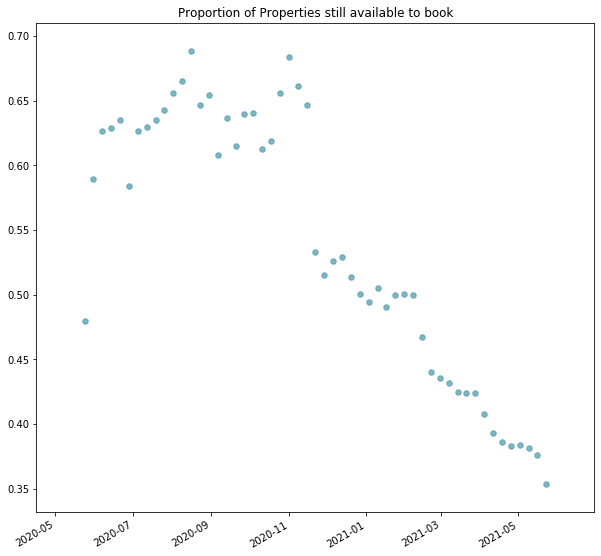

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(weekly_pricing.index, weekly_pricing.available, s = 30, color = '#539caf', alpha = 0.75)

ax.set_title('Proportion of Properties still available to book')
fig.autofmt_xdate()

**Looking at the properties that are listed and how big they are**

First we need to read in the new dataset

In [14]:
properties_df = pd.read_csv('./listings.csv')
properties_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6422,https://www.airbnb.com/rooms/6422,20200518140247,2020-05-18,Nashville Charm,"Turn of century bungalow in historic, hip East...",1920 historic bungalow backs up to city park w...,"Turn of century bungalow in historic, hip East...",none,Historic East Nashville is home to many new an...,...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,5.01
1,20847,https://www.airbnb.com/rooms/20847,20200518140247,2020-05-19,East Nashville Retro Ranch!,This listing is no longer available for short ...,-Retro Ranch is nestled in a quiet part of Sou...,This listing is no longer available for short ...,none,"Many local favorites, including live music, th...",...,f,f,strict_14_with_grace_period,t,t,3,0,3,0,1.11
2,25341,https://www.airbnb.com/rooms/25341,20200518140247,2020-05-18,East Nashville Retro Ranch BR #2,This listing is no longer available for short ...,-Retro Ranch is nestled in a quiet part of Sou...,This listing is no longer available for short ...,none,"Many local favorites, including live music, th...",...,f,f,strict_14_with_grace_period,t,t,3,0,3,0,0.89
3,25342,https://www.airbnb.com/rooms/25342,20200518140247,2020-05-18,East Nashville Retro Ranch BR #3,This listing is no longer available for short ...,Retro Ranch is nestled in a quiet part of Sout...,This listing is no longer available for short ...,none,"Many local favorites, including live music, th...",...,f,f,strict_14_with_grace_period,t,t,3,0,3,0,0.04
4,25613,https://www.airbnb.com/rooms/25613,20200518140247,2020-05-18,Room in Historic East Nashville Craftsman Home,Serve up some sweet sounds on the piano and wi...,"Our gorgeous 3,000 square foot, architecturall...",Serve up some sweet sounds on the piano and wi...,none,This home is in a walkable neighborhood with i...,...,t,f,moderate,t,t,1,0,1,0,4.16


In [15]:
properties_df.shape

(7129, 106)

We can drop the majority of columns here, only keeping a few that relate to the size of the property

In [16]:
sizing_df = properties_df[['accommodates', 'beds', 'square_feet']]

In [17]:
sizing_df.shape

(7129, 3)

In [18]:
sizing_df = sizing_df.dropna(subset=['square_feet'])

In [19]:
sizing_df.shape

(15, 3)

Unfortunately only a few Nashville hosts publish the size of their property in square feet. We can therefore drop this column and evaluate the size of Nashville properties based on the number of people they accomodate.

As a minimum standard we want to make sure that each property has at least one bed for every two people for a comfortable stay

In [20]:
sizing_df = properties_df[['accommodates', 'beds']]
sizing_df = sizing_df[sizing_df['beds'] != 0]
sizing_df['beds_pp'] = sizing_df['beds']/sizing_df['accommodates']
sizing_df = sizing_df[sizing_df['beds_pp'] > 0.5]
sizing_df.shape

(2127, 3)

In [21]:
sizes = sizing_df.groupby('accommodates').count()

In [22]:
sizes

,beds,beds_pp
accommodates,,
1,103,103
2,102,102
3,155,155
4,169,169
5,110,110
6,243,243
7,85,85
8,192,192
9,33,33


(0, 18)

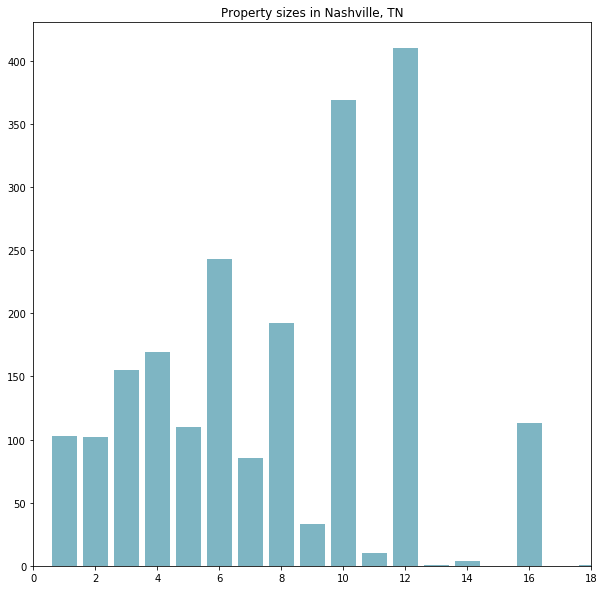

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(sizes.index, sizes.beds, color = '#539caf', alpha = 0.75)
ax.set_title('Property sizes in Nashville, TN')
ax.set_xlim(0,18)

Lets compare to some other cities

In [41]:
def get_airbnb_sizes(city):
    '''
    INPUT:
    city - a string of the city name for the data we want to analyse 
    OUTPUT:
    sizes - a dataframe containing a count of the properties in the city grouped by the number of guests they can accommodate

    Provides a dataframe that can be used to determine the spread of airbnb sizes across a city from their airbnb listings csv file
    '''
    df = pd.read_csv(f'./{city}_listings.csv')
    sizing_df = df[['accommodates', 'beds']]
    sizing_df = sizing_df[sizing_df['beds'] != 0]
    sizing_df['beds_pp'] = sizing_df['beds']/sizing_df['accommodates']
    sizing_df = sizing_df[sizing_df['beds_pp'] > 0.5]
    sizing_df = sizing_df[sizing_df['accommodates'] < 20]
    sizes = sizing_df.groupby('accommodates').count()
    
    return sizes

In [42]:
Asheville_airbnbs = get_airbnb_sizes('Asheville')

In [45]:
Austin_airbnbs = get_airbnb_sizes('Austin')

In [44]:
Boston_airbnbs = get_airbnb_sizes('Boston')

(0, 18)

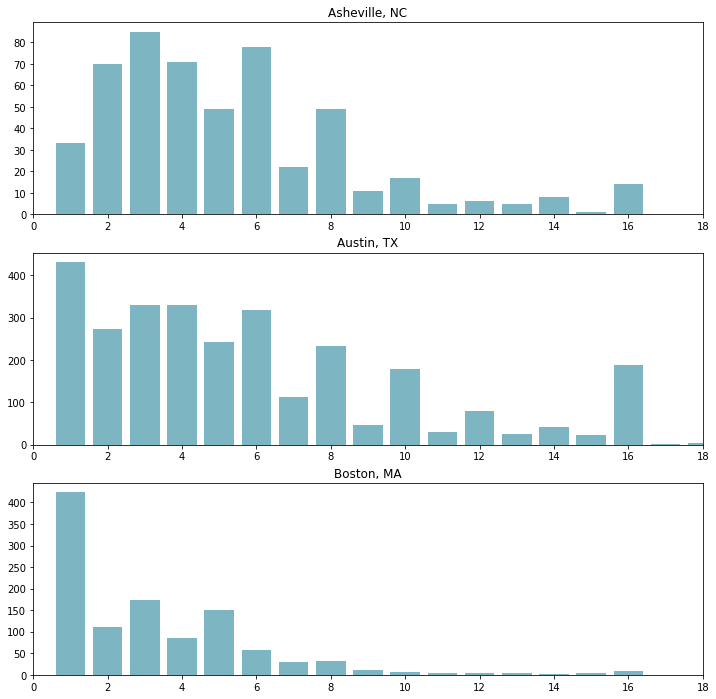

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,12))
ax1.bar(Asheville_airbnbs.index, Asheville_airbnbs.beds, color = '#539caf', alpha = 0.75)
ax1.set_title('Asheville, NC')
ax1.set_xlim(0,18)

ax2.bar(Austin_airbnbs.index, Austin_airbnbs.beds, color = '#539caf', alpha = 0.75)
ax2.set_title('Austin, TX')
ax2.set_xlim(0,18)

ax3.bar(Boston_airbnbs.index, Boston_airbnbs.beds, color = '#539caf', alpha = 0.75)
ax3.set_title('Boston, MA')
ax3.set_xlim(0,18)

**Finding out what features result in a good review**

In [91]:
# Getting a list of features for our model
features = ['review_scores_rating', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'calculated_host_listings_count', 
            'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
            'calculated_host_listings_count_shared_rooms', 'reviews_per_month']

In [92]:
df = properties_df[features]

In [93]:
df.head()

,review_scores_rating,instant_bookable,is_business_travel_ready,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,99.0,f,f,strict_14_with_grace_period,1,0,1,0,5.01
1,94.0,f,f,strict_14_with_grace_period,3,0,3,0,1.11
2,96.0,f,f,strict_14_with_grace_period,3,0,3,0,0.89
3,93.0,f,f,strict_14_with_grace_period,3,0,3,0,0.04
4,97.0,t,f,moderate,1,0,1,0,4.16


In [94]:
df.shape

(7129, 9)

In [95]:
df.describe()

,review_scores_rating,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,6069.000000,7129.000000,7129.000000,7129.000000,7129.000000,6102.000000
mean,96.508980,22.277037,21.712863,0.367934,0.004068,2.353858
std,5.797801,40.209730,40.302555,1.133110,0.075733,2.056499
min,20.000000,1.000000,0.000000,0.000000,0.000000,0.020000
25%,96.000000,1.000000,1.000000,0.000000,0.000000,0.760000
50%,98.000000,3.000000,2.000000,0.000000,0.000000,1.880000
75%,100.000000,19.000000,19.000000,0.000000,0.000000,3.377500
max,100.000000,155.000000,155.000000,10.000000,2.000000,32.590000


In [96]:
# removing rows without a review score rating as that is our target and no reviews per month
df = df.dropna(subset=['review_scores_rating','reviews_per_month'], axis=0)

In [97]:
# Encoding the categorical variables
cat_cols = ['instant_bookable', 'is_business_travel_ready', 'cancellation_policy']
for col in  cat_cols:
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)

In [98]:
# Preparing our X and y
X = df.drop('review_scores_rating', axis=1)
y = df['review_scores_rating']

# Splitting train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate the model
lm_model = LinearRegression(normalize=True)

# Fit the model
lm_model.fit(X_train, y_train)

# Predict our y test values
y_test_preds = lm_model.predict(X_test)

# Score our y test
r2_score(y_test, y_test_preds)


0.040290017057743266

To find out which of our features had the biggest impact we need to order them by their coefficients

In [110]:
coefs_df = pd.DataFrame()
coefs_df['feature'] = X_train.columns
coefs_df['coefs'] = lm_model.coef_
coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
coefs_df

,feature,coefs,abs_coefs
8,cancellation_policy_super_strict_30,-2.898720,2.898720
3,calculated_host_listings_count_shared_rooms,-2.659718,2.659718
9,cancellation_policy_super_strict_60,-1.154752,1.154752
5,instant_bookable_t,-0.937909,0.937909
7,cancellation_policy_strict_14_with_grace_period,-0.228951,0.228951
6,cancellation_policy_moderate,0.156188,0.156188
1,calculated_host_listings_count_entire_homes,-0.062871,0.062871
0,calculated_host_listings_count,0.051753,0.051753
2,calculated_host_listings_count_private_rooms,-0.048414,0.048414
4,reviews_per_month,0.046179,0.046179


[Text(0, 0, 'calculated_host_listings_count'),
 Text(0, 0, 'calculated_host_listings_count_entire_homes'),
 Text(0, 0, 'calculated_host_listings_count_private_rooms'),
 Text(0, 0, 'calculated_host_listings_count_shared_rooms'),
 Text(0, 0, 'reviews_per_month'),
 Text(0, 0, 'instant_bookable_t'),
 Text(0, 0, 'cancellation_policy_moderate')]

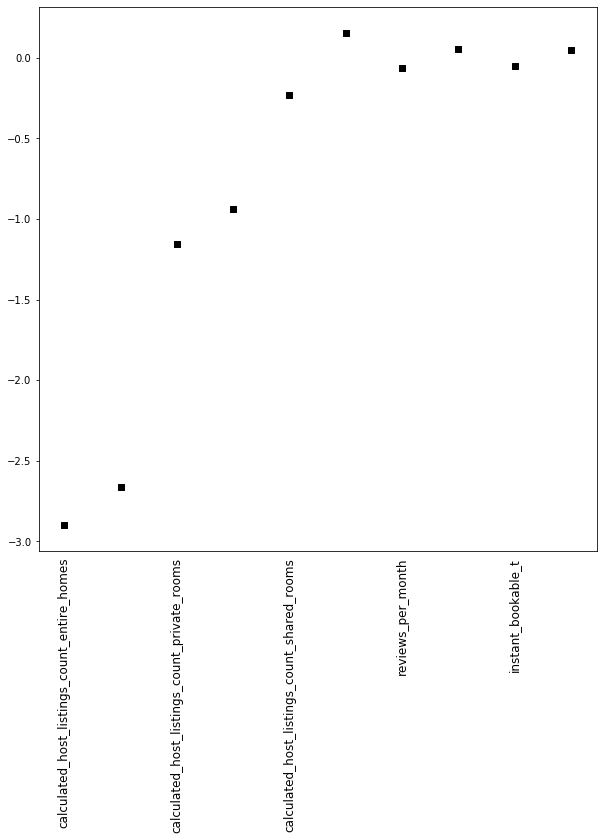

In [113]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(x=pd.np.arange(coefs_df.shape[0]), 
           marker='s', s=30, 
           y=coefs_df['coefs'], color='black')
ax.xaxis.set_ticks_position('none')
ax.set_xticklabels(X_train.columns, rotation=90, fontsize=12)